## Group 12

Rita Palma 20240661 <br>
Santiago Taylor 20240542 <br>
Martim Tavares 20240508 <br>
Maria Inês Assunção 20211605 <br>

# Library imports

In [1]:
!pip install keras_tuner
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.1 MB/s eta 0:00:00


In [ ]:
# python standard library imports
from typing import Self, Any
from pathlib import Path
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.utils import image_dataset_from_directory

# augmentation operations
from keras.layers import Rescaling, RandomBrightness, RandomFlip, RandomRotation, RandomZoom, RandAugment, RandomGrayscale, RandomSharpness
from keras_cv.layers import RandomGaussianBlur, RandomCutout, AugMix
from keras.layers import Pipeline

# model building imports
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.ops import add

# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import LearningRateScheduler, CSVLogger

import keras_tuner as kt

d:\Miniconda\envs\DeepLearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir_path = Path("/content/drive/My Drive/NOVA/DL_project")

In [ ]:
df = pd.read_csv(root_dir_path / "rare_species/metadata.csv")
#df['file_path'] = df['file_path'].apply(lambda x: Path("rare_species") / x)

In [14]:
df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

In [ ]:
df.shape

(11983, 7)

In [16]:
df["family"].value_counts()

# 202 classes

family
cercopithecidae      300
dactyloidae          300
formicidae           291
plethodontidae       270
carcharhinidae       270
                    ... 
megapodiidae          30
tropiduridae          30
parulidae             30
brachypteraciidae     30
siluridae             29
Name: count, Length: 202, dtype: int64

In [17]:
df["kingdom"].value_counts()

# 1 kingdom

kingdom
animalia    11983
Name: count, dtype: int64

In [18]:
df["phylum"].value_counts()
# 5 phylum

phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64

# Class Distributions

In [8]:
# checking class distribution
families_with_29_or_30 = df["family"].value_counts()[df["family"].value_counts().isin([29, 30])].index
num_families = len(families_with_29_or_30)
print(f"{num_families} families with only 29 or 30 instances")

118 families with only 29 or 30 instances


In [ ]:
num_families_above_90 = (df['family'].value_counts() > 90).sum()
print(f"{num_families_above_90} family classes with more than 90 instances")

23 family classes with more than 90 instances


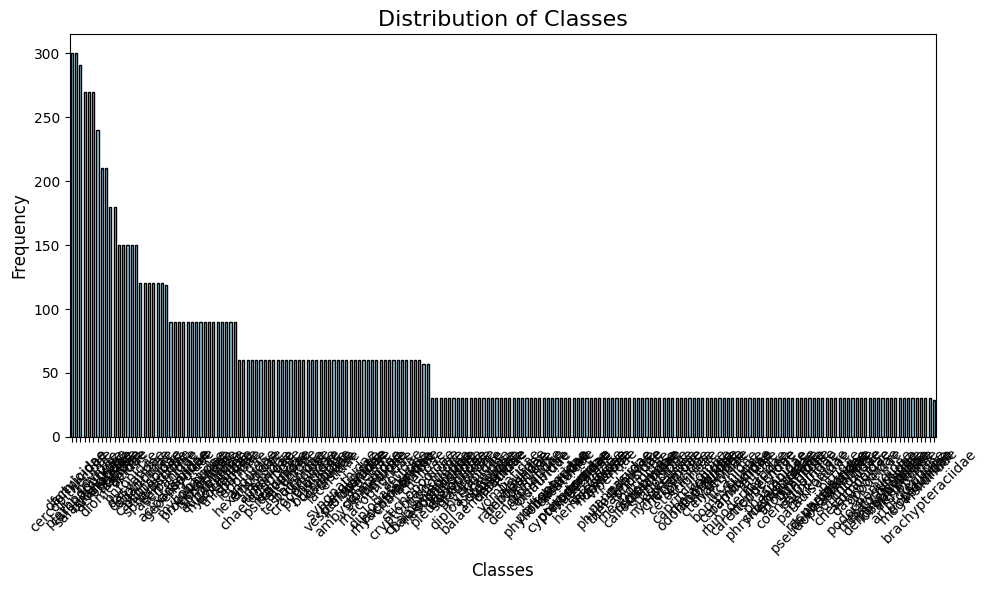

In [10]:
# histogram to check classes imbalances
plt.figure(figsize=(10, 6))
df['family'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

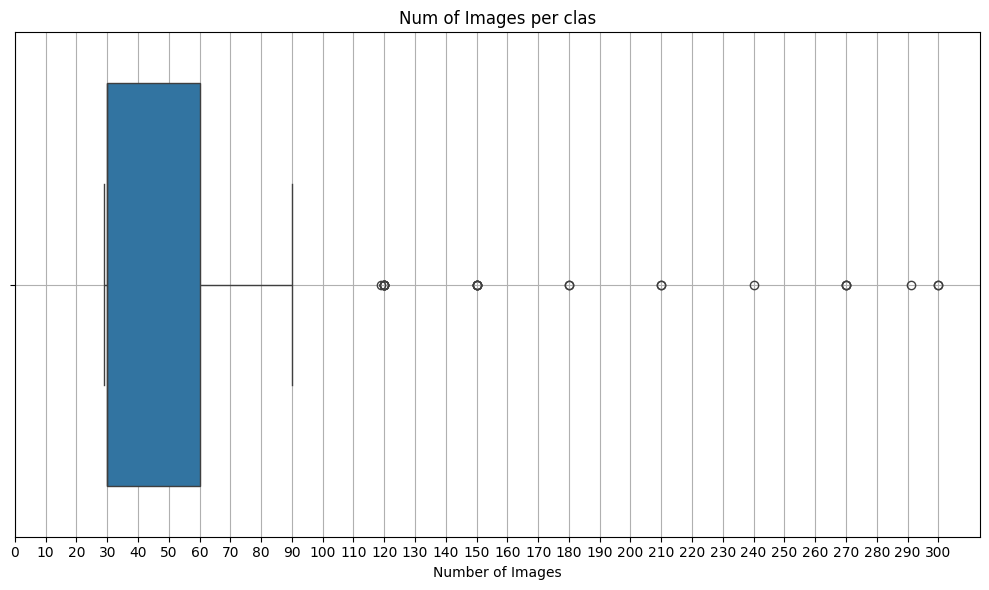

In [11]:
# box plot of classes distributions
value_counts = df['family'].value_counts()
plt.figure(figsize=(10, 6))
sns.boxplot(x=value_counts.values)
plt.xticks(range(0, int(value_counts.max()) + 10, 10))
plt.title("Num of Images per clas")
plt.xlabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

### Data Inconsistencies

In [12]:
# no duplicated entries found
df[df.duplicated()]

Empty DataFrame
Columns: [rare_species_id, eol_content_id, eol_page_id, kingdom, phylum, family, file_path]
Index: []

In [20]:
# no missing values found
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [rare_species_id, eol_content_id, eol_page_id, kingdom, phylum, family, file_path]
Index: []

In [19]:
# check for invalid files
invalid_files = []

for path in df['file_path']:
    try:
        with Image.open(path) as img:
            img.verify()
    except Exception as e:
        invalid_files.append((str(path), str(e)))

print(f"{len(invalid_files)} invalid images")

d:\Miniconda\envs\DeepLearning\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


0 invalid images


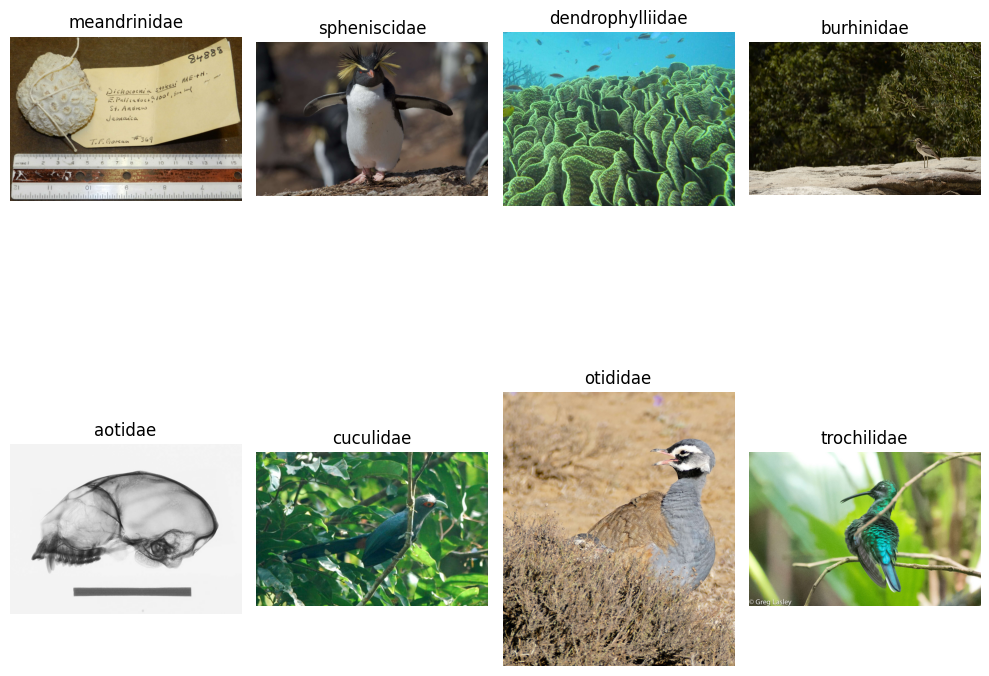

In [ ]:
random_images = random.sample(list(df['file_path']), 8)

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(random_images, 1):
    img = Image.open(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.axis('off')

    label = df.loc[df['file_path'] == img_path, 'family'].values[0]
    plt.title(label)
plt.tight_layout()
plt.show()

In [25]:
# check for different image formats
image_formats = df['file_path'].astype(str).str.lower().str.split('.').str[-1].value_counts()
print(image_formats)

file_path
jpg    11983
Name: count, dtype: int64


In [26]:
# check for fifferent image color modes

def get_image_color_modes(image_paths):
    color_modes = set()
    for image_path in image_paths:
        try:
            img = Image.open(image_path)
            color_modes.add(img.mode)
            img.close()
        except Exception as e:
            print(f"Error opening: {image_path}: {e}")
    return color_modes

image_paths = df['file_path'].astype(str).tolist()

color_modes = get_image_color_modes(image_paths)

print("Color modes:")
for mode in color_modes:
    print(mode)

d:\Miniconda\envs\DeepLearning\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Color modes:
L
RGB
CMYK


In [ ]:
def convert_images_to_rgb(image_paths):
    for image_path in image_paths:
        try:
            with Image.open(image_path) as img:
                if img.mode != 'RGB':
                    rgb_img = img.convert('RGB')
                    rgb_img.save(image_path)
        except Exception as e:
            print(f"Error converting: {image_path}: {e}")

image_paths = df['file_path'].astype(str).tolist()
convert_images_to_rgb(image_paths)

d:\Miniconda\envs\DeepLearning\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


# Data split into folders

In [ ]:
'''
dest_dir = Path("data")
dest_dir.mkdir(exist_ok=True)

# Stratified split
train, other = train_test_split(df, test_size=0.3, stratify=df['family'], random_state=1)
val, test = train_test_split(other, test_size=0.5, stratify=other['family'], random_state=1)

def load_images(split, split_name):
    for row in split.iterrows():
        label = row['family']
        src = row['file_path']
        dst_folder = dest_dir / split_name / label
        dst_folder.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src, dst_folder / src.name)

# Apply for each split
load_images(train, "train")
load_images(val, "val")
load_images(test, "test")
'''

# Load Data

In [17]:
data_dir_path = root_dir_path / "data"

train_dir_path = data_dir_path / "train"
val_dir_path = data_dir_path / "val"
test_dir_path = data_dir_path / "test"

In [ ]:
n_classes = 202
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    verbose=False
)

In [ ]:
val_ds = image_dataset_from_directory(
    val_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

In [ ]:
test_ds = image_dataset_from_directory(
    test_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

# Normalizing Images


In [ ]:
# Normalize pixel valuse to the range [0, 1]
rescaler =  Rescaling(scale=1 / 255.0)

train_ds = train_ds.map(lambda x, y: (rescaler(x), y))
val_ds = val_ds.map(lambda x, y: (rescaler(x), y))
test_ds = test_ds.map(lambda x, y: (rescaler(x), y))

# Augmentation

In [ ]:
def show_image(ds, augmentation_layer):
    """
    Takes one image from the dataset, applies a specific augmentation layer and prints the augmented image

    Goal: verify effects of each augmentation before training
    """
    for images, labels in train_ds.take(1):
        # Get the first image in the batch and apply augmentation
        image = images[0]
        augmented_images = augmentation_layer(images, training=True)

        augmented_image = augmented_images[0]


        # Show the images
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        axs[0].imshow(image.numpy())
        axs[0].axis('off')
        axs[0].set_title("Original Image")

        axs[1].imshow(augmented_image.numpy())
        axs[1].axis('off')
        axs[1].set_title("Augmented Image")

        plt.show()

## Augmentations tested:
- BRIGHTNESS: helps simulate different lighting conditions
- BLUR: helps simulate camera imperfections and depth variations
- FLIP: flips image horizontally/vertically introducing different spatial perspectives
- ROTATION: rotates images by a certain angle
- ZOOM: helps simulate different distances and with scale variance
- CUT OUT: random patches of the image are erased

- RANDOM AUGMENTATION: applies a random combination of augmentations from a predefined set
- AUGMENTATION MIX: combines multiple stochastic augmentations in parallel, then mixes them

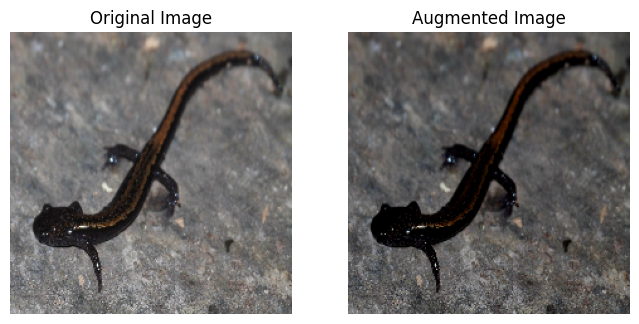

In [ ]:
# RANDOM BRIGHTNESS

show_image(ds=train_ds, augmentation_layer=RandomBrightness(factor=0.2, value_range=value_range))

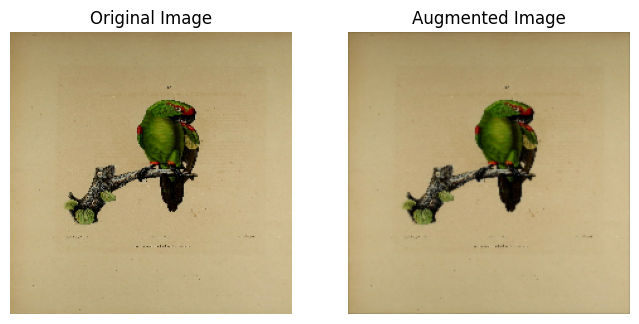

In [ ]:
# RANDOM GAUSSIAN BLUR

show_image(ds=train_ds, augmentation_layer=RandomGaussianBlur(factor=0.7, kernel_size=3))

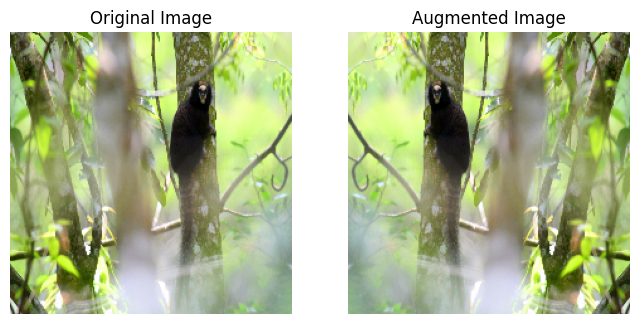

In [ ]:
# RANDOM FLIP
show_image(ds=train_ds, augmentation_layer=RandomFlip(mode="horizontal"))

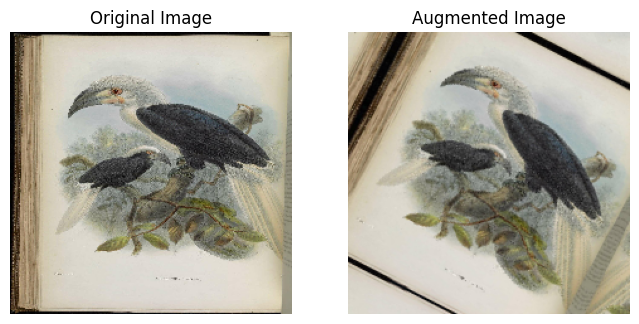

In [ ]:
# RANDOM ROTATION

show_image(ds=train_ds, augmentation_layer=RandomRotation(factor=0.15, fill_mode="reflect"))

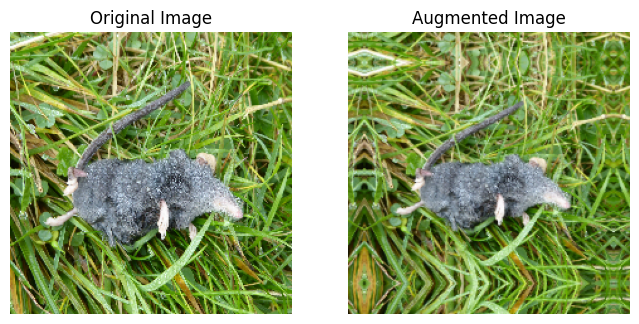

In [ ]:
# RANDOM ZOOM

show_image(ds=train_ds, augmentation_layer=RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)))

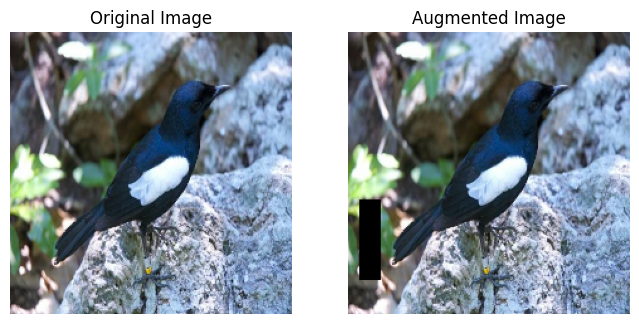

In [ ]:
# RANDOM CUTOUT

show_image(ds=train_ds, augmentation_layer=RandomCutout(height_factor=0.5, width_factor=0.5))

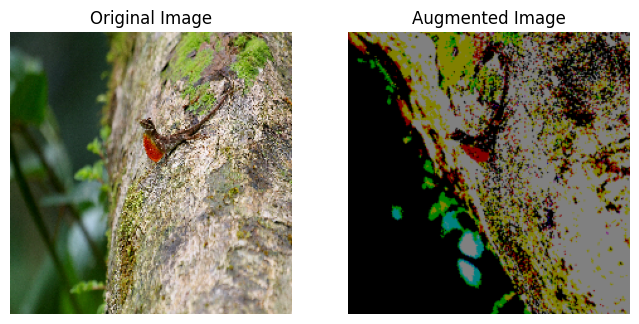

In [ ]:
# RANDOM AUGMENTATION

show_image(ds=train_ds, augmentation_layer=RandAugment(value_range=value_range))

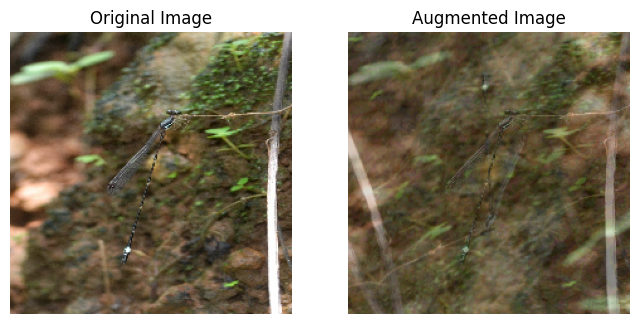

In [ ]:
# AUGMENTATION MIX

show_image(ds=train_ds, augmentation_layer=AugMix(value_range=value_range))

In [ ]:
# sample dataset by batches (batch_size=64)
# take 86 batches --> 2752 images
train_sample = train_ds.take(43)

# take 18 batches --> 576
val_sample = val_ds.take(9)
test_sample = test_ds.take(9)

In [ ]:
# simple model to test different augmentations
model = Sequential(
    layers = [
        Input(shape=input_shape),
        Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(n_classes, activation="softmax"),
    ],
    name = "baseline_model"
)

In [ ]:
optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
metrics_file_path = root_dir_path / "Augmentation Metrics"/ "base_line.csv"

# metrics logging callback
# callback that logs training and validation metrics (loss, accuracy) to a CSV file after each epoch
metrics_callback = CSVLogger(metrics_file_path)

In [ ]:
epochs = 10

In [ ]:
# Model without augmentation
_ = model.fit(
    train_sample,
    validation_data=val_sample,
    epochs=epochs,
    callbacks=metrics_callback,
    verbose=1
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1481s 34s/step - accuracy: 0.0204 - auc: 0.6123 - f1_score: 0.0016 - loss: 5.1805 - val_accuracy: 0.0208 - val_auc: 0.7720 - val_f1_score: 0.0021 - val_loss: 4.7537
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.0603 - auc: 0.6748 - f1_score: 0.0057 - loss: 5.0094 - val_accuracy: 0.0781 - val_auc: 0.7766 - val_f1_score: 0.0035 - val_loss: 4.6326
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0694 - auc: 0.6928 - f1_score: 0.0061 - loss: 4.9405 - val_accuracy: 0.0868 - val_auc: 0.7991 - val_f1_score: 0.0051 - val_loss: 4.5681
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0763 - auc: 0.7052 - f1_score: 0.0062 - loss: 4.8753 - val_accuracy: 0.1267 - val_auc: 0.8000 - val_f1_score: 0.0069 - val_loss: 4.5061
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.0881 - auc: 0.7283 - f1_score: 0.0089 - loss: 4.7719 - val_accuracy: 0.0556 - val_auc: 0.7960 - val_f1_score: 0.0054 - val_loss: 4.5

In [ ]:
model.evaluate(
    test_sample,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.1215277761220932,
 'auc': 0.7786489725112915,
 'f1_score': 0.01282436028122902,
 'loss': 4.417697906494141}

## Augmentation combinations:
- BRIGHTNESS + FLIP + ROTATION: combines lighting variations with spatial transformations to simulate real life conditions and different camera angles
- FLIP + ZOOM + BLUR: combines different perspectives/scales and captures possible camera quality problems
- ROTATION + ZOOM + CUTOUT: simulates difference in scale and angles and promotes robustness to missing information
- BRIGHTNESS + FLIP + ZOOM + CUTOUT: combines ligthing and spatial variations and helps with possible missing infrmation
- RANDOM AUGMENTATION
- AUGMENTATION MIX

In [ ]:
combination1 = Pipeline(
    [
        RandomBrightness(factor=0.2, value_range=value_range),
        RandomFlip(mode="horizontal"),
        RandomRotation(factor=0.15, fill_mode="reflect"),
    ],
    name="Brightness-Flip-Rotation"
)

combination2 = Pipeline(
    [
        RandomFlip(mode="horizontal"),
        RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)),
        RandomGaussianBlur(factor=0.7, kernel_size=3),
    ],
    name="Flip-Zoom-Blur"
)

combination3 = Pipeline(
    [
        RandomRotation(factor=0.15, fill_mode="reflect"),
        RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)),
        RandomCutout(height_factor=0.5, width_factor=0.5),
    ],
    name="Rotation-Zoom-Cutout"
)

combination4 = Pipeline(
    [
        RandomBrightness(factor=0.2, value_range=value_range),
        RandomFlip(mode="horizontal"),
        RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)),
        RandomCutout(height_factor=0.5, width_factor=0.5),
    ],
    name="Brightness-Flip-Zoom-Cutout"
)

combination5 = Pipeline(
    [
        RandAugment(value_range=value_range)
    ],
    name="RandAugment"
)

combination6 = Pipeline(
    [
        AugMix(value_range=value_range)
    ],
    name="AugMix"
)

In [ ]:
augmentation_combinations = [combination1, combination2, combination3, combination4, combination5, combination6]

augmentation_files1 = []

for augmentation in augmentation_combinations:
    train_aug = train_sample.map(lambda x, y: (augmentation(x, training= True), y))

    aug_model = Sequential(
      layers = [
          Input(shape=input_shape),
          Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(n_classes, activation="softmax"),
      ],
      name = "aug_model"
    )

    optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
    loss = CategoricalCrossentropy(name="loss")

    # metrics
    categorical_accuracy = CategoricalAccuracy(name="accuracy")
    auc = AUC(name="auc")
    f1_score = F1Score(average="macro", name="f1_score")
    metrics = [categorical_accuracy, auc, f1_score]

    aug_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    metrics_file_path = root_dir_path / "Augmentation Metrics"/ f"{augmentation.name}.csv"
    metrics_callback = CSVLogger(metrics_file_path)

    augmentation_files1.append(f"{augmentation.name}.csv")

    print(f"----------- {augmentation.name} -----------")

    aug_model.fit(
        train_aug,
        validation_data=val_sample,
        epochs=epochs,
        callbacks=metrics_callback,
        verbose=1
    )


----------- Brightness-Flip-Rotation -----------
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.0201 - auc: 0.6021 - f1_score: 0.0012 - loss: 5.1773 - val_accuracy: 0.0208 - val_auc: 0.7876 - val_f1_score: 0.0021 - val_loss: 4.6700
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.0368 - auc: 0.6629 - f1_score: 0.0022 - loss: 5.0451 - val_accuracy: 0.0434 - val_auc: 0.7818 - val_f1_score: 0.0012 - val_loss: 4.6540
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0487 - auc: 0.6787 - f1_score: 0.0030 - loss: 4.9946 - val_accuracy: 0.0729 - val_auc: 0.7922 - val_f1_score: 0.0029 - val_loss: 4.5847
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0564 - auc: 0.6890 - f1_score: 0.0045 - loss: 4.9509 - val_accuracy: 0.0330 - val_auc: 0.8034 - val_f1_score: 0.0019 - val_loss: 4.6058
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0554 - auc: 0.6946 - f1_score: 0.0049 - loss: 4.9168 - val_accuracy: 0.0625 - val_auc: 

In [ ]:
augmentation_files1

['Brightness-Flip-Rotation.csv',
 'Flip-Zoom-Blur.csv',
 'Rotation-Zoom-Cutout.csv',
 'Brightness-Flip-Zoom-Cutout.csv',
 'RandAugment.csv',
 'AugMix.csv']

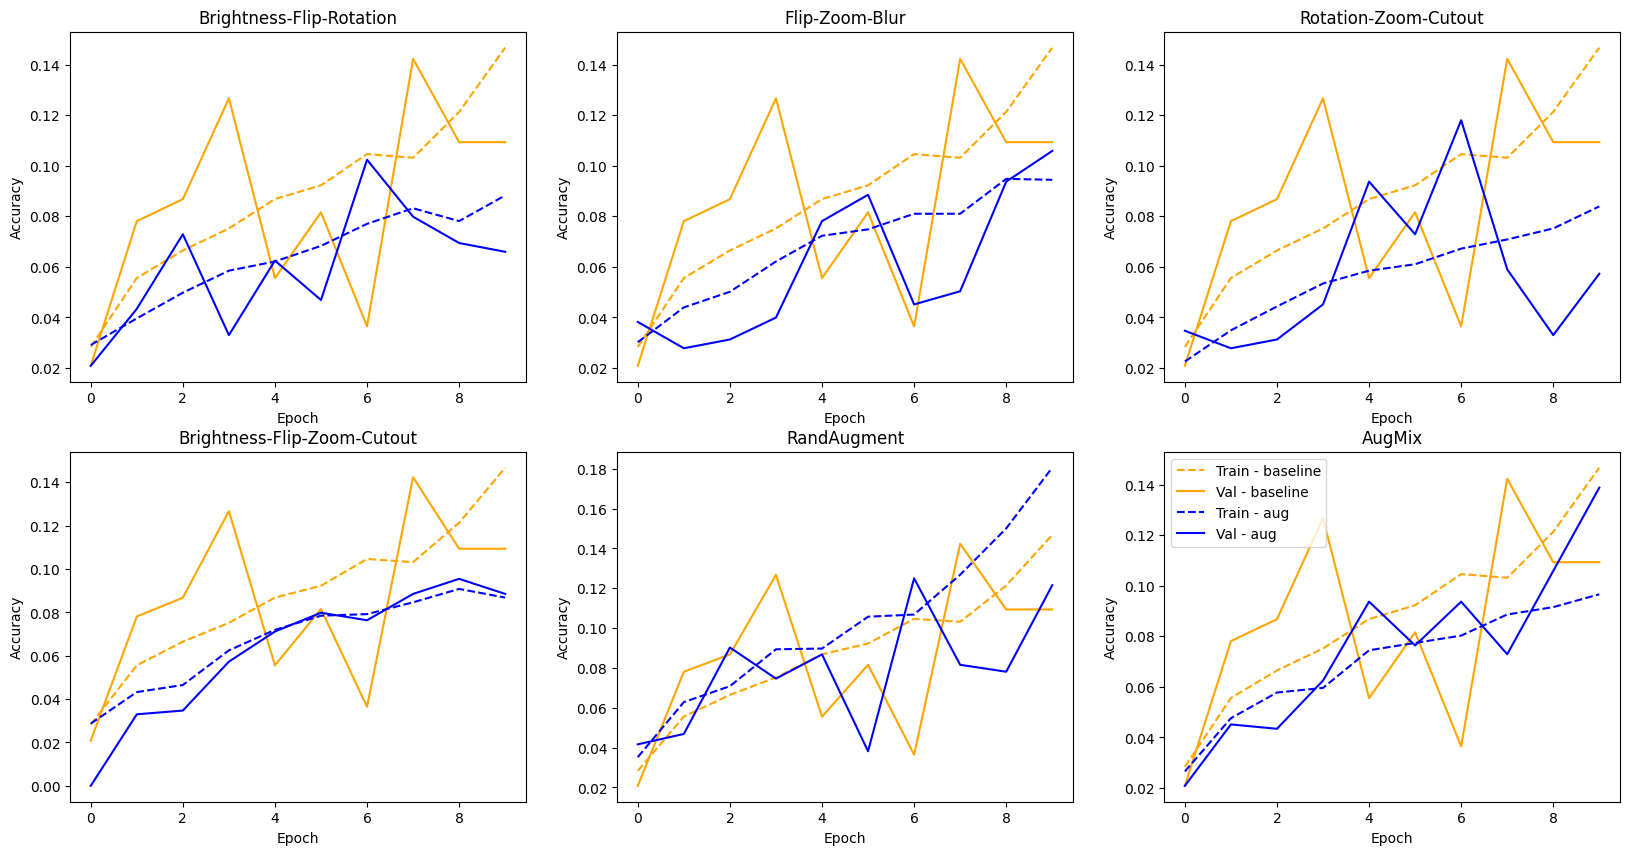

In [ ]:
df_base = pd.read_csv(root_dir_path / "Augmentation Metrics"/ "base_line.csv")

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, files in enumerate(augmentation_files1):

  df_aug = pd.read_csv(root_dir_path / "Augmentation Metrics"/ files)

  row = i // 3
  col = i % 3
  ax = axs[row, col]

  ax.plot(df_base["epoch"], df_base["accuracy"], label="Train - baseline", color="orange", linestyle="dashed")
  ax.plot(df_base["epoch"], df_base["val_accuracy"], label="Val - baseline", color="orange")
  ax.plot(df_aug["epoch"], df_aug["accuracy"], label=f"Train - aug", color="blue", linestyle="dashed")
  ax.plot(df_aug["epoch"], df_aug["val_accuracy"], label=f"Val - aug", color="blue")

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  ax.set_title(files.replace(".csv", ""))
ax.legend()
plt.show()

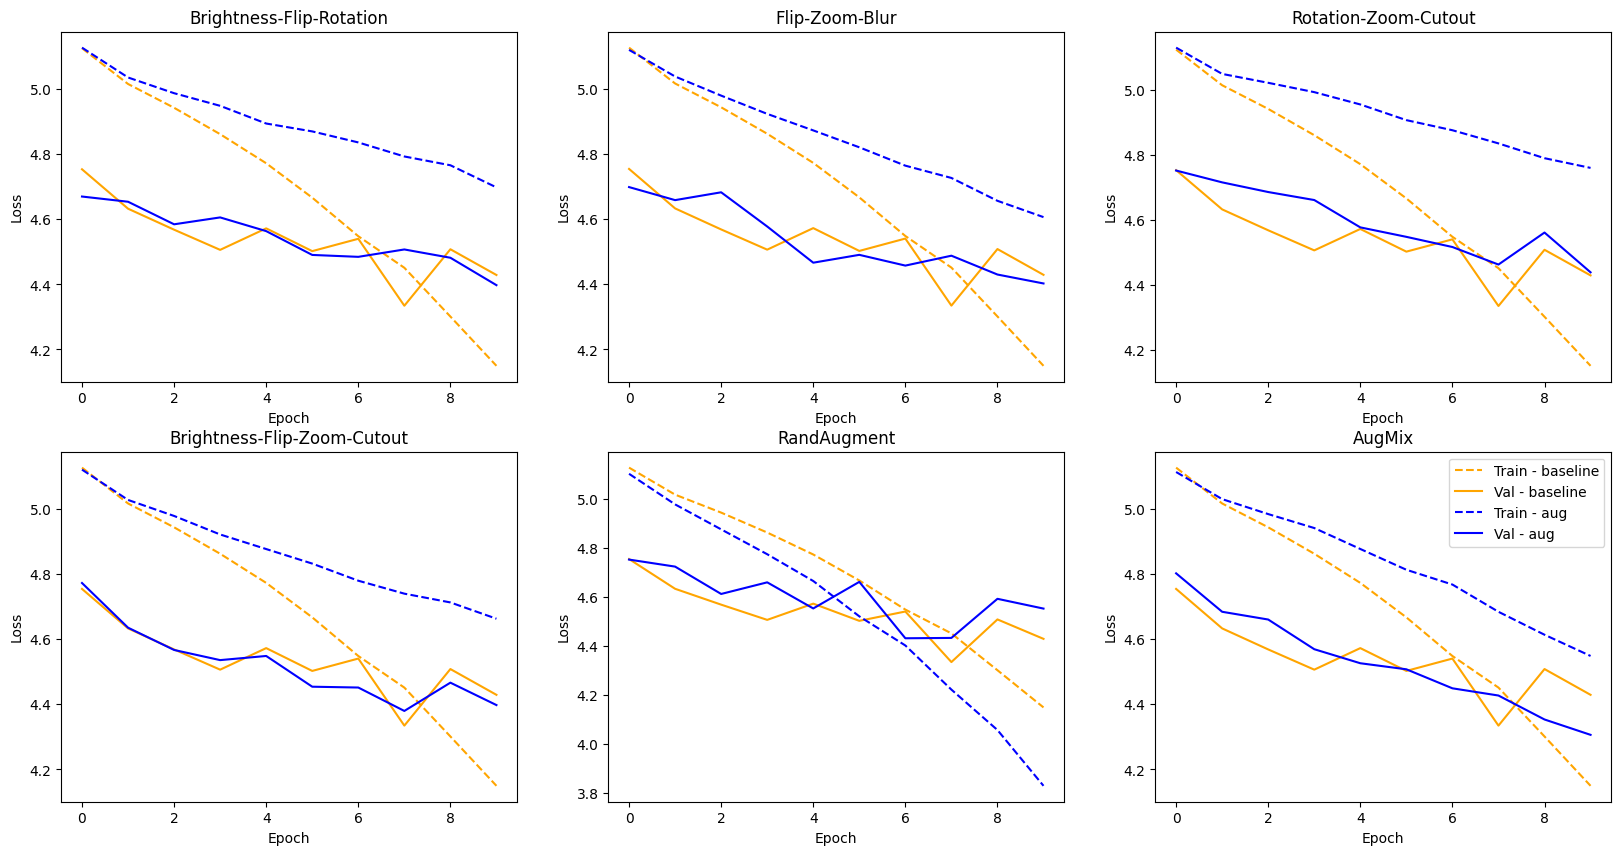

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, files in enumerate(augmentation_files1):

  df_aug = pd.read_csv(root_dir_path / "Augmentation Metrics"/ files)

  row = i // 3
  col = i % 3
  ax = axs[row, col]

  ax.plot(df_base["epoch"], df_base["loss"], label="Train - baseline", color="orange", linestyle="dashed")
  ax.plot(df_base["epoch"], df_base["val_loss"], label="Val - baseline", color="orange")
  ax.plot(df_aug["epoch"], df_aug["loss"], label=f"Train - aug", color="blue", linestyle="dashed")
  ax.plot(df_aug["epoch"], df_aug["val_loss"], label=f"Val - aug", color="blue")

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.set_title(files.replace(".csv", ""))
ax.legend()
plt.show()

## RESULTS
1. Combinations that showed the worst performance (lowest validation accuraccy and F1 score) --> discard
- BRIGHTNESS + FLIP + ROTATION
- ROTATION + ZOOM + CUTOUT

2. Train and validation are close, which shows good signs of generalization --> keep
- BRIGHTNESS + FLIP + ZOOM + CUTOUT

3. --> keep for now
- FLIP + ZOOM + BLUR
- RANDOM AUGMENTATION
- AUGMENTATION MIX

## Additional augmentations tested:
- GRAY SCALE: converts input images to grayscale with a specified factor, can be useful for data augmentation and training models to be robust to color variations
- SHARPNESS: first performs a blur, then blends between the original image and the processed image, it adjusts the clarity of the edges in an image, ranging from blurred to enhanced sharpness.

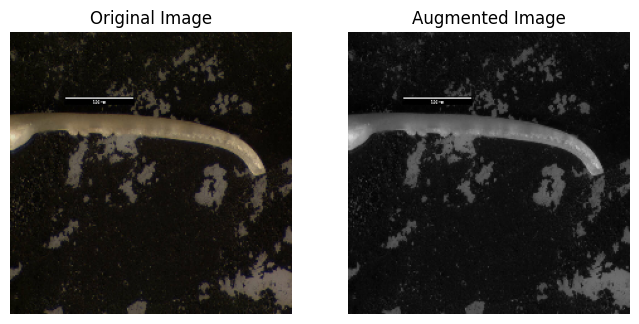

In [ ]:
# RANDOM GRAYSCALE

show_image(ds=train_ds, augmentation_layer=RandomGrayscale(factor=0.5))

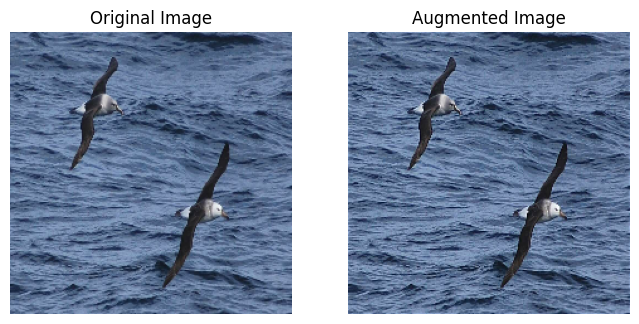

In [ ]:
# RANDOM SHARPNESS

show_image(ds=train_ds, augmentation_layer=RandomSharpness(factor=(0.3, 0.8), value_range=value_range))

## Additional augmentation combinations:
- FLIP + ZOOM + GRAYSCALE + SHARPNESS:
- RANDOM AUGMENT + GRAYSCALE:
- CUTOUT + GRAYSCALE + FLIP + BLUR:

In [ ]:
combination7 = Pipeline(
    [
        RandomFlip(mode="horizontal"),
        RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)),
        RandomGrayscale(factor=0.5),
        RandomSharpness(factor=(0.3, 0.8), value_range=value_range),
    ],
    name="Flip-Zoom-Grayscale-Sharpness"
)

combination8 = Pipeline(
    [
        RandAugment(value_range=value_range),
        RandomGrayscale(factor=0.5),
    ],
    name="RandAugment-Grayscale"
)

combination9 = Pipeline(
    [
        RandomCutout(height_factor=0.5, width_factor=0.5),
        RandomGrayscale(factor=0.5),
        RandomFlip(mode="horizontal"),
        RandomGaussianBlur(factor=0.7, kernel_size=3),
    ],
    name="Cutout-Grayscale-Flip-Blur"
)


In [ ]:
augmentation_combinations = [combination7, combination8, combination9]

augmentation_files2 = []

for augmentation in augmentation_combinations:
    train_aug = train_sample.map(lambda x, y: (augmentation(x, training= True), y))

    aug_model = Sequential(
      layers = [
          Input(shape=input_shape),
          Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(n_classes, activation="softmax"),
      ],
      name = "aug_model"
    )

    optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
    loss = CategoricalCrossentropy(name="loss")

    # metrics
    categorical_accuracy = CategoricalAccuracy(name="accuracy")
    auc = AUC(name="auc")
    f1_score = F1Score(average="macro", name="f1_score")
    metrics = [categorical_accuracy, auc, f1_score]

    aug_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    metrics_file_path = root_dir_path / "Augmentation Metrics"/ f"{augmentation.name}.csv"
    metrics_callback = CSVLogger(metrics_file_path)

    augmentation_files2.append(f"{augmentation.name}.csv")

    print(f"----------- {augmentation.name} -----------")

    aug_model.fit(
        train_aug,
        validation_data=val_sample,
        epochs=epochs,
        callbacks=metrics_callback,
        verbose=1
    )


----------- Flip-Zoom-Grayscale-Sharpness -----------
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.0200 - auc: 0.6087 - f1_score: 0.0017 - loss: 5.1773 - val_accuracy: 0.0330 - val_auc: 0.7569 - val_f1_score: 0.0017 - val_loss: 4.7427
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.0336 - auc: 0.6585 - f1_score: 0.0025 - loss: 5.0563 - val_accuracy: 0.0833 - val_auc: 0.7779 - val_f1_score: 0.0026 - val_loss: 4.7212
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.0522 - auc: 0.6762 - f1_score: 0.0044 - loss: 5.0207 - val_accuracy: 0.0486 - val_auc: 0.7912 - val_f1_score: 0.0031 - val_loss: 4.6676
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.0487 - auc: 0.6795 - f1_score: 0.0036 - loss: 4.9989 - val_accuracy: 0.0295 - val_auc: 0.7848 - val_f1_score: 0.0026 - val_loss: 4.7143
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.0485 - auc: 0.6829 - f1_score: 0.0029 - loss: 4.9813 - val_accuracy: 0.0538 - val

In [ ]:
augmentation_files2 = ["Flip-Zoom-Grayscale-Sharpness.csv", "RandAugment-Grayscale.csv", "Cutout-Grayscale-Flip-Blur.csv"]
augmentation_files2

['Flip-Zoom-Grayscale-Sharpness.csv',
 'RandAugment-Grayscale.csv',
 'Cutout-Grayscale-Flip-Blur.csv']

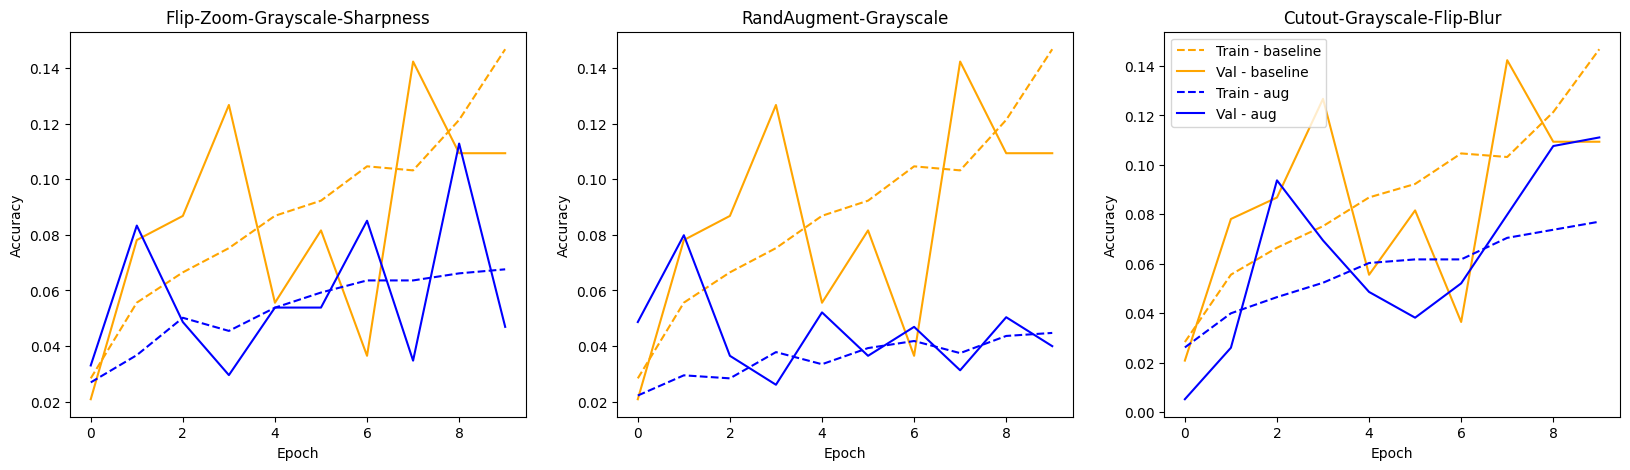

In [ ]:
df_base = pd.read_csv(root_dir_path / "Augmentation Metrics"/ "base_line.csv")

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, files in enumerate(augmentation_files2):

  df_aug = pd.read_csv(root_dir_path / "Augmentation Metrics"/ files)

  ax = axs[i]

  ax.plot(df_base["epoch"], df_base["accuracy"], label="Train - baseline", color="orange", linestyle="dashed")
  ax.plot(df_base["epoch"], df_base["val_accuracy"], label="Val - baseline", color="orange")
  ax.plot(df_aug["epoch"], df_aug["accuracy"], label=f"Train - aug", color="blue", linestyle="dashed")
  ax.plot(df_aug["epoch"], df_aug["val_accuracy"], label=f"Val - aug", color="blue")

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  ax.set_title(files.replace(".csv", ""))
ax.legend()
plt.show()

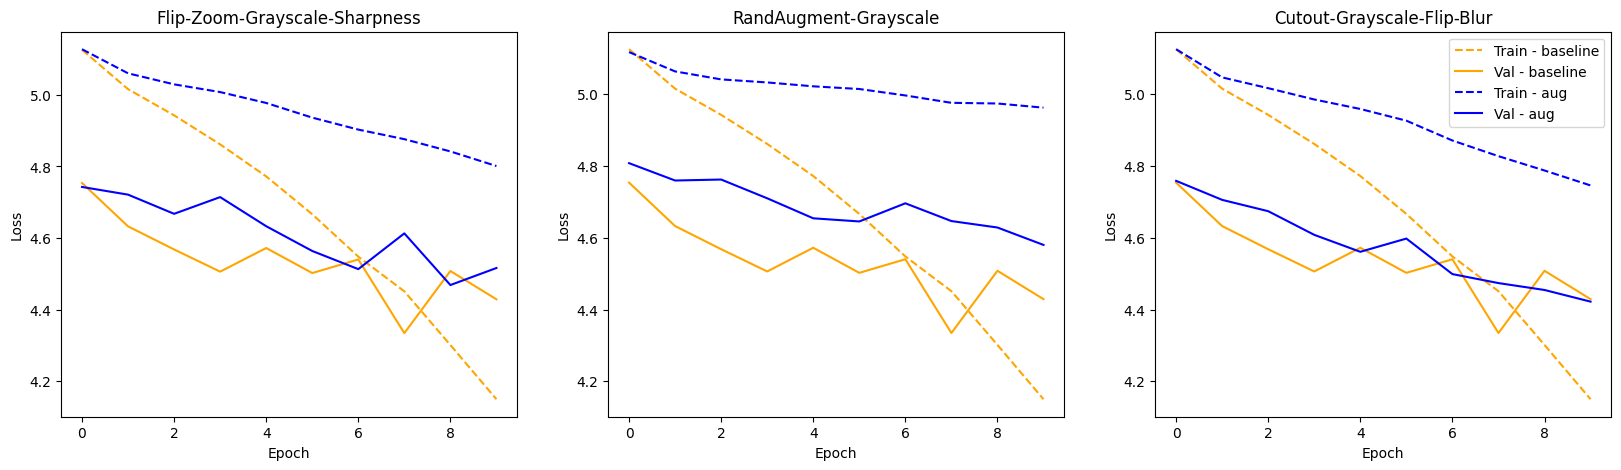

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, files in enumerate(augmentation_files2):

  df_aug = pd.read_csv(root_dir_path / "Augmentation Metrics"/ files)

  ax = axs[i]

  ax.plot(df_base["epoch"], df_base["loss"], label="Train - baseline", color="orange", linestyle="dashed")
  ax.plot(df_base["epoch"], df_base["val_loss"], label="Val - baseline", color="orange")
  ax.plot(df_aug["epoch"], df_aug["loss"], label=f"Train - aug", color="blue", linestyle="dashed")
  ax.plot(df_aug["epoch"], df_aug["val_loss"], label=f"Val - aug", color="blue")

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.set_title(files.replace(".csv", ""))
ax.legend()
plt.show()

## RESULTS
1. Validation accuracy is either very unstable or barely improves --> discard
- FLIP + ZOOM + GRAYSCALE + SHARPNESS
- RANDOM AUGMENT + GRAYSCALE

2. More balanced, accuracy shows better trends, highest F1 score --> keep
- CUTOUT + GRAYSCALE + FLIP + BLUR

## Combinations to fine tune
- CUTOUT + GRAYSCALE + FLIP + BLUR
- BRIGHTNESS + FLIP + ZOOM + CUTOUT

## Maybe keep for the future:
- FLIP + ZOOM + BLUR
- RANDOM AUGMENTATION
- AUGMENTATION MIX

# Brightness-Flip-Zoom-Cutout

In [ ]:
def build_model(hp):

    # Augmentation parameters to tune

    brightness_factor = hp.Choice("brightness_factor", [0.1, 0.2, 0.3, 0.4])
    flip_mode = hp.Choice("flip_mode", ["horizontal", "horizontal_and_vertical"])
    zoom_factor = hp.Choice("zoom_factor", [0.1, 0.2, 0.3, 0.4])
    cutout_factor = hp.Choice("cutout_factor", [0.1, 0.2, 0.3, 0.4])

    # Augmentation pipeline
    augmentation1 = Pipeline(
        [
            RandomBrightness(factor=brightness_factor, value_range=value_range),
            RandomFlip(mode=flip_mode),
            RandomZoom(height_factor=(0.0, zoom_factor), width_factor=(0.0, zoom_factor)),
            RandomCutout(height_factor=cutout_factor, width_factor=cutout_factor),
        ],
    )

    train_aug = train_sample.map(lambda x, y: (augmentation1(x, training= True), y))

    # model
    model1 = Sequential(
        layers = [
            Input(shape=input_shape),
            Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(n_classes, activation="softmax"),
        ],
        name = "model1"
    )

    optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
    loss = CategoricalCrossentropy(name="loss")

    # metrics
    categorical_accuracy = CategoricalAccuracy(name="accuracy")
    auc = AUC(name="auc")
    f1_score = F1Score(average="macro", name="f1_score")
    metrics = [categorical_accuracy, auc, f1_score]

    model1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Save augmented dataset as a model attribute it can be used later
    model1.train_aug = train_aug

    return model1

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="augmentation_tuning",
    project_name="Brightness-Flip-Zoom-Cutout"
)

# Before search, extract the augmented dataset from one build_model run
sample_model = build_model(kt.HyperParameters())
train_aug = sample_model.train_aug

tuner.search(
        train_aug,
        validation_data=val_sample,
        epochs=epochs,
        verbose=1
    )

Trial 10 Complete [00h 46m 50s]
val_accuracy: 0.1493055522441864

Best val_accuracy So Far: 0.1684027761220932
Total elapsed time: 07h 45m 19s


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Brightness Factor:", best_hp.get("brightness_factor"))
print("Best Flip Mode:", best_hp.get("flip_mode"))
print("Best Zoom Factor:", best_hp.get("zoom_factor"))
print("Best Cutout factor:", best_hp.get("cutout_factor"))

Best Brightness Factor: 0.4
Best Flip Mode: horizontal
Best Zoom Factor: 0.2
Best Cutout factor: 0.1


In [ ]:
final_augmentation1 = Pipeline(
        [
            RandomBrightness(factor=0.4, value_range=value_range),
            RandomFlip(mode="horizontal"),
            RandomZoom(height_factor=(0.0, 0.2), width_factor=(0.0, 0.2)),
            RandomCutout(height_factor=0.1, width_factor=0.1),
        ],
        name="Brightness-Flip-Zoom-Cutout"
    )

In [ ]:
train_aug1 = train_sample.map(lambda x, y: (final_augmentation1(x, training= True), y))

model_aug1 = Sequential(
    layers = [
        Input(shape=input_shape),
        Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(n_classes, activation="softmax"),
    ],
    name = "final_augmentation1_model"
)

optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model_aug1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

metrics_file_path = root_dir_path / "Augmentation Metrics"/ "final_augmentation1.csv"

# metrics logging callback
# callback that logs training and validation metrics (loss, accuracy) to a CSV file after each epoch
metrics_callback = CSVLogger(metrics_file_path)

# Model without augmentation
_ = model_aug1.fit(
    train_aug1,
    validation_data=val_sample,
    epochs=epochs,
    callbacks=metrics_callback,
    verbose=1
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0227 - auc: 0.5964 - f1_score: 0.0018 - loss: 5.2181 - val_accuracy: 0.0295 - val_auc: 0.7674 - val_f1_score: 0.0026 - val_loss: 4.7880
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.0506 - auc: 0.6552 - f1_score: 0.0030 - loss: 5.0647 - val_accuracy: 0.1042 - val_auc: 0.7729 - val_f1_score: 0.0044 - val_loss: 4.6547
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.0622 - auc: 0.6702 - f1_score: 0.0041 - loss: 4.9918 - val_accuracy: 0.0851 - val_auc: 0.7801 - val_f1_score: 0.0030 - val_loss: 4.6014
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.0616 - auc: 0.6812 - f1_score: 0.0047 - loss: 4.9479 - val_accuracy: 0.1076 - val_auc: 0.7817 - val_f1_score: 0.0088 - val_loss: 4.5551
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.0777 - auc: 0.6901 - f1_score: 0.0069 - loss: 4.9209 - val_accuracy: 0.1181 - val_auc: 0.7847 - val_f1_score: 0.0070 - val_loss: 4.4968


In [ ]:
model_aug1.evaluate(
    test_sample,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.1545138955116272,
 'auc': 0.7970618009567261,
 'f1_score': 0.010097525082528591,
 'loss': 4.352627754211426}

# Cutout-Grayscale-Flip-Blur

In [ ]:
def build_model(hp):

    # Augmentation parameters to tune
    cutout_factor = hp.Choice("cutout_factor", [0.1, 0.2, 0.3, 0.4])
    grayscale_factor = hp.Choice("grayscale_factor", [0.1, 0.2, 0.3, 0.4])
    flip_mode = hp.Choice("flip_mode", ["horizontal", "horizontal_and_vertical"])
    blur_factor = hp.Choice("blur_factor", [0.1, 0.2, 0.3, 0.4])
    blur_kernel = hp.Choice("blur_kernel", [3, 5, 7])

    # Augmentation pipeline
    augmentation2 = Pipeline(
        [
            RandomCutout(height_factor=cutout_factor, width_factor=cutout_factor),
            RandomGrayscale(factor=grayscale_factor),
            RandomFlip(mode=flip_mode),
            RandomGaussianBlur(factor=blur_factor, kernel_size=blur_kernel),
        ],
    )

    train_aug = train_sample.map(lambda x, y: (augmentation2(x, training= True), y))

    # model
    model2 = Sequential(
        layers = [
            Input(shape=input_shape),
            Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(n_classes, activation="softmax"),
        ],
        name = "model2"
    )

    optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
    loss = CategoricalCrossentropy(name="loss")

    # metrics
    categorical_accuracy = CategoricalAccuracy(name="accuracy")
    auc = AUC(name="auc")
    f1_score = F1Score(average="macro", name="f1_score")
    metrics = [categorical_accuracy, auc, f1_score]

    model2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Save augmented dataset as a model attribute it can be used later
    model2.train_aug = train_aug

    return model2

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="augmentation_tuning",
    project_name="Cutout-Grayscale-Flip-Blur"
)

# Before search, extract the augmented dataset from one build_model run
sample_model = build_model(kt.HyperParameters())
train_aug = sample_model.train_aug

tuner.search(
        train_aug,
        validation_data=val_sample,
        epochs=epochs,
        verbose=1
    )

Trial 10 Complete [00h 55m 39s]
val_accuracy: 0.125

Best val_accuracy So Far: 0.1545138955116272
Total elapsed time: 09h 05m 49s


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Cutout Factor:", best_hp.get("cutout_factor"))
print("Best Grayscale Factor:", best_hp.get("grayscale_factor"))
print("Best Flip Mode:", best_hp.get("flip_mode"))
print("Best Blur Factor:", best_hp.get("blur_factor"))
print("Best Blur Kernel Size:", best_hp.get("blur_kernel"))

Best Cutout Factor: 0.3
Best Grayscale Factor: 0.1
Best Flip Mode: horizontal_and_vertical
Best Blur Factor: 0.3
Best Blur Kernel Size: 3


In [ ]:
final_augmentation2 = Pipeline(
    [
        RandomCutout(height_factor=0.3, width_factor=0.3),
        RandomGrayscale(factor=0.1),
        RandomFlip(mode="horizontal_and_vertical"),
        RandomGaussianBlur(factor=0.3, kernel_size=3),
    ],
    name="Cutout-Grayscale-Flip-Blur"
)

In [ ]:
train_aug2 = train_sample.map(lambda x, y: (final_augmentation2(x, training= True), y))

model_aug2 = Sequential(
    layers = [
        Input(shape=input_shape),
        Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(n_classes, activation="softmax"),
    ],
    name = "final_augmentation2_model"
)

optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model_aug2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

metrics_file_path = root_dir_path / "Augmentation Metrics"/ "final_augmentation2.csv"

# metrics logging callback
# callback that logs training and validation metrics (loss, accuracy) to a CSV file after each epoch
metrics_callback = CSVLogger(metrics_file_path)

# Model without augmentation
_ = model_aug2.fit(
    train_aug2,
    validation_data=val_sample,
    epochs=epochs,
    callbacks=metrics_callback,
    verbose=1
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 805s 19s/step - accuracy: 0.0234 - auc: 0.5970 - f1_score: 0.0035 - loss: 5.1961 - val_accuracy: 0.0052 - val_auc: 0.7477 - val_f1_score: 6.6007e-04 - val_loss: 4.7652
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.0310 - auc: 0.6442 - f1_score: 0.0021 - loss: 5.0809 - val_accuracy: 0.0312 - val_auc: 0.7629 - val_f1_score: 0.0026 - val_loss: 4.6828
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.0460 - auc: 0.6640 - f1_score: 0.0026 - loss: 5.0220 - val_accuracy: 0.0642 - val_auc: 0.7607 - val_f1_score: 0.0029 - val_loss: 4.6444
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.0608 - auc: 0.6758 - f1_score: 0.0036 - loss: 4.9652 - val_accuracy: 0.0990 - val_auc: 0.7745 - val_f1_score: 0.0047 - val_loss: 4.5740
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.0733 - auc: 0.6831 - f1_score: 0.0060 - loss: 4.9478 - val_accuracy: 0.1128 - val_auc: 0.7685 - val_f1_score: 0.0065 - val_loss:

In [ ]:
model_aug2.evaluate(
    test_sample,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.1111111119389534,
 'auc': 0.8008668422698975,
 'f1_score': 0.006522585637867451,
 'loss': 4.394632816314697}

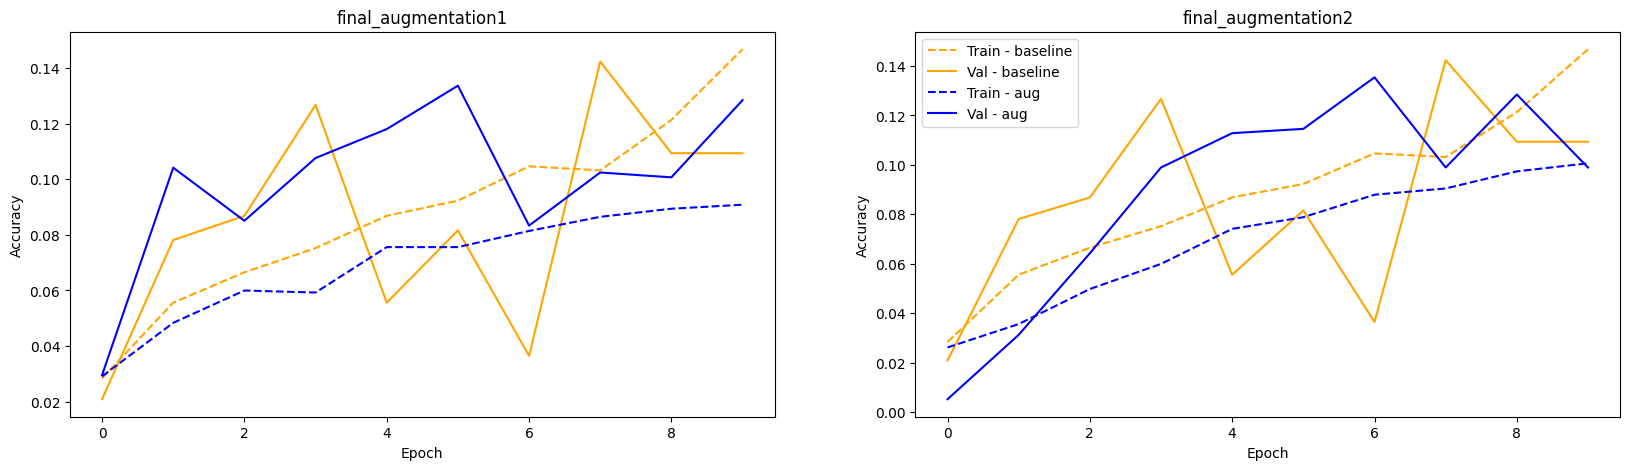

In [23]:
df_base = pd.read_csv(root_dir_path / "Augmentation Metrics"/ "base_line.csv")

final_augmentations = ["final_augmentation1.csv", "final_augmentation2.csv"]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, files in enumerate(final_augmentations):

  df_aug = pd.read_csv(root_dir_path / "Augmentation Metrics"/ files)

  ax = axs[i]

  ax.plot(df_base["epoch"], df_base["accuracy"], label="Train - baseline", color="orange", linestyle="dashed")
  ax.plot(df_base["epoch"], df_base["val_accuracy"], label="Val - baseline", color="orange")
  ax.plot(df_aug["epoch"], df_aug["accuracy"], label=f"Train - aug", color="blue", linestyle="dashed")
  ax.plot(df_aug["epoch"], df_aug["val_accuracy"], label=f"Val - aug", color="blue")

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  ax.set_title(files.replace(".csv", ""))
ax.legend()
plt.show()

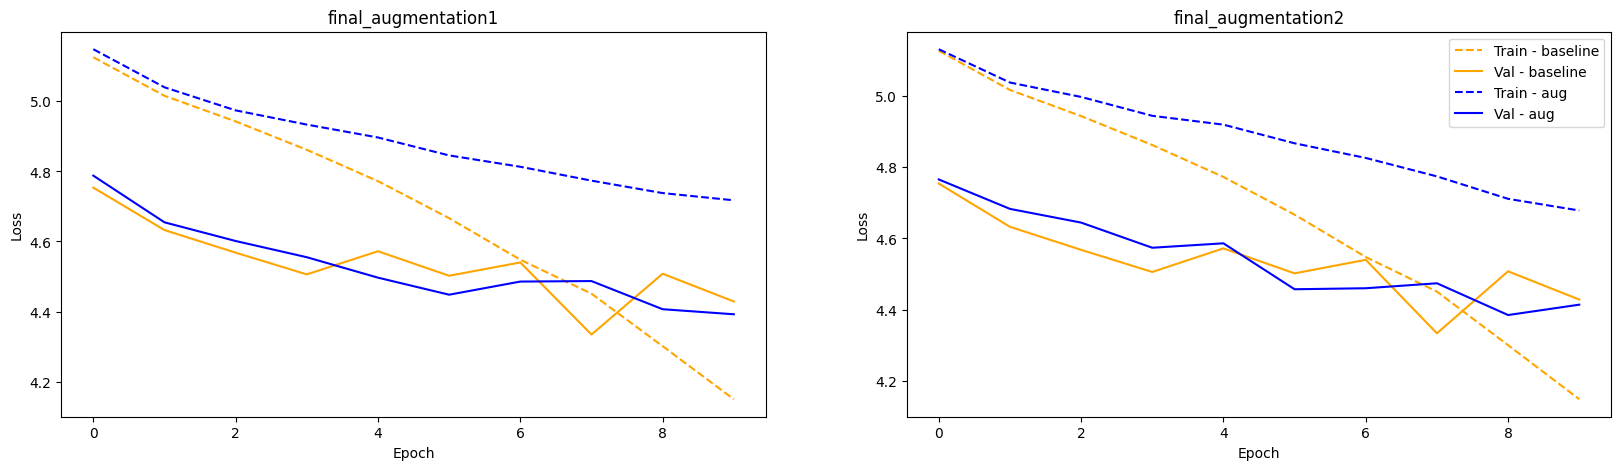

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, files in enumerate(final_augmentations):

  df_aug = pd.read_csv(root_dir_path / "Augmentation Metrics"/ files)

  ax = axs[i]

  ax.plot(df_base["epoch"], df_base["loss"], label="Train - baseline", color="orange", linestyle="dashed")
  ax.plot(df_base["epoch"], df_base["val_loss"], label="Val - baseline", color="orange")
  ax.plot(df_aug["epoch"], df_aug["loss"], label=f"Train - aug", color="blue", linestyle="dashed")
  ax.plot(df_aug["epoch"], df_aug["val_loss"], label=f"Val - aug", color="blue")

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.set_title(files.replace(".csv", ""))
ax.legend()
plt.show()

## Test scores for:
<b>1. Baseline model</b> <br>
{'accuracy': 0.1215277761220932, <br>
 'auc': 0.7786489725112915, <br>
 'f1_score': 0.01282436028122902, <br>
 'loss': 4.417697906494141} <br>

<b>2. final_augmentation1_model</b> <br>
{'accuracy': 0.1545138955116272,<br>
 'auc': 0.7970618009567261,<br>
 'f1_score': 0.010097525082528591,<br>
 'loss': 4.352627754211426}<br>

<b>3. final_augmentation2_model</b> <br>
{'accuracy': 0.1111111119389534,<br>
 'auc': 0.8008668422698975,<br>
 'f1_score': 0.006522585637867451,<br>
 'loss': 4.394632816314697} <br>


# Next steps for model training:
Try different augmentation techniques:
1. Try final_augmentation1 --> "Brightness-Flip-Zoom-Cutout"
2. Try final_augmentation2 --> "Cutout-Grayscale-Flip-Blur"
3. Try progressive augmentations:
  - start with smaller tranformations: flip, zoom
  - in later epochs introduce stronger transformations: grayscale, blur, brightness, cutout

--> try different combinations of these 3 points